In [3]:
# Imports

from collections import Counter, defaultdict
from pathlib import Path
import json
import re
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [4]:
# Paths

data_path = "../data/raw-refs-abs"
table_path = "../reports/tables"
figure_path = "../reports/figures"

In [5]:
# Find all .jsonl below data_path, recursively
jsonl_files = sorted(Path(data_path).rglob("*.jsonl"))
print(f"Found {len(jsonl_files)} jsonl files under {Path(data_path).resolve()}")
for p in jsonl_files[:5]:
    print("  -", p)

Found 5 jsonl files under /Users/martinbergsto/Documents/NTNU/Semester9/Prosjektoppgave/ML-catalogue/literature-mining/data/raw-refs-abs
  - ../data/raw-refs-abs/ml_manufacturing_optimization/ml_manufacturing_optimization.jsonl
  - ../data/raw-refs-abs/ml_planning_production/ml_planning_production.jsonl
  - ../data/raw-refs-abs/ml_product_design/ml_product_design.jsonl
  - ../data/raw-refs-abs/ml_product_development/ml_product_development.jsonl
  - ../data/raw-refs-abs/ml_production_optimization/ml_production_optimization.jsonl


In [6]:
# Load per-query meta from "<query_id>_meta.json" in each folder

def load_folder_meta(folder: Path) -> dict:
    exact = folder / f"{folder.name}_meta.json"
    if exact.exists():
        try:
            return json.loads(exact.read_text(encoding="utf-8"))
        except Exception:
            pass
    for p in sorted(folder.glob("*_meta.json")):
        try:
            return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            continue
    return {}

query_meta = {}
for folder in {f.parent for f in jsonl_files}:
    meta = load_folder_meta(folder)
    qid = meta.get("query_id") or folder.name
    if qid not in query_meta:
        query_meta[qid] = {**meta, "folder": str(folder)}

print(f"Loaded meta for {len(query_meta)} queries from *_meta.json files.")


Loaded meta for 5 queries from *_meta.json files.


In [7]:
# Helpers 

def norm_text(s) -> str | None:
    # Normalize to lowercase string; ignore containers ([], {}, sets)
    if s is None:
        return None
    if isinstance(s, (list, tuple, set, dict)):
        return None
    s = str(s).strip().lower()
    if not s:
        return None
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s:/.-]", "", s)
    return s or None

def ref_key_from_refdoc(ref: dict) -> tuple:
    # Stable key: DOI -> title -> (id|sourcetitle) -> raw fallback
    doi = norm_text(ref.get("doi"))
    title = norm_text(ref.get("title"))
    rid = norm_text(ref.get("id"))
    src = norm_text(ref.get("sourcetitle"))
    if doi:
        return ("doi", doi)
    if title:
        return ("title", title)
    if rid or src:
        return ("id_src", f"{rid}|{src}")
    return ("raw", norm_text(json.dumps(ref, ensure_ascii=False))[:120] if ref else "unknown")

def update_meta(meta_store: dict, key: tuple, ref: dict):
    # Keep first non-null values as a representative sample
    cur = meta_store.setdefault(key, {"doi": None, "title": None, "sourcetitle": None})
    for f in ("doi", "title", "sourcetitle"):
        if cur[f] is None and ref.get(f) is not None:
            cur[f] = ref.get(f)

def infer_query_id_from_path(fp: Path) -> str:
    # Use immediate parent folder name as query_id
    return fp.parent.name

def iter_refdocs(rec: dict) -> list[dict]:
    # ref_docs is usually [] or a list of dicts, accept a single dict too
    refs = rec.get("ref_docs") or []
    if isinstance(refs, dict):
        return [refs]
    if isinstance(refs, list):
        return [r for r in refs if isinstance(r, dict)]
    return []


In [8]:
# Parse and aggregate (with empty/malformed checks)

ref_counter = Counter()
ref_meta = {}                         # key -> meta
ref_per_query = defaultdict(Counter)  # key -> {query_id: count}
ref_per_file = defaultdict(Counter)   # key -> {filepath: count}

query_ref_totals = Counter()          # query_id -> total refs counted
query_record_totals = Counter()       # query_id -> number of article rows

n_rows = 0
n_refs = 0
empty_ref_lists = 0                   # ref_docs == []
malformed_ref_docs = 0                # ref_docs present but malformed

for fp in tqdm(jsonl_files, desc="Files"):
    qid_from_path = infer_query_id_from_path(fp)
    with fp.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
            except json.JSONDecodeError:
                continue

            n_rows += 1
            query_id = qid_from_path or rec.get("query_id") or Path(fp.name).stem
            query_record_totals[query_id] += 1

            raw_refs = rec.get("ref_docs", None)
            refs = iter_refdocs(rec)

            # Empty list (quite common...)
            if isinstance(raw_refs, list) and len(raw_refs) == 0:
                empty_ref_lists += 1

            # Count as malformed only if present and not a clean list/dict of dicts
            is_malformed = False
            if raw_refs is not None:
                if isinstance(raw_refs, list):
                    is_malformed = any((r is not None and not isinstance(r, dict)) for r in raw_refs)
                elif not isinstance(raw_refs, dict):
                    is_malformed = True
            if is_malformed:
                malformed_ref_docs += 1

            # Count all references
            for ref in refs:
                key = ref_key_from_refdoc(ref)
                ref_counter[key] += 1
                ref_per_query[key][query_id] += 1
                ref_per_file[key][str(fp)] += 1
                update_meta(ref_meta, key, ref)
                query_ref_totals[query_id] += 1
                n_refs += 1

print(
    f"Parsed {n_rows} records; counted {n_refs} references; "
    f"unique ref keys: {len(ref_counter):,}; "
    f"empty ref_docs lists: {empty_ref_lists}; malformed ref_docs: {malformed_ref_docs}"
)


Files: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

Parsed 15752 records; counted 256056 references; unique ref keys: 168,840; empty ref_docs lists: 10325; malformed ref_docs: 0


In [9]:
# Build overall table

rows = []
for key, cnt in ref_counter.most_common():
    meta = ref_meta.get(key, {})
    by_query = ref_per_query.get(key, {})
    rows.append(
        {
            "count": cnt,
            "n_queries": len(by_query),
            "doi": meta.get("doi"),
            "title": meta.get("title"),
            "sourcetitle": meta.get("sourcetitle"),
            "ref_key_type": key[0],
            "ref_key_value": key[1],
        }
    )

ref_df = (
    pd.DataFrame(rows)
      .sort_values(["count", "n_queries"], ascending=[False, False])
      .reset_index(drop=True)
)

print("Columns :", list(ref_df.columns))

Columns : ['count', 'n_queries', 'doi', 'title', 'sourcetitle', 'ref_key_type', 'ref_key_value']


In [10]:
# Per-query wide table 

seen_queries = sorted({q for c in ref_per_query.values() for q in c.keys()})
ordered_queries = [q for q in query_meta.keys() if q in seen_queries] + [
    q for q in seen_queries if q not in query_meta
]

if seen_queries:
    data = []
    for key, _ in ref_counter.most_common():
        row = {q: ref_per_query[key].get(q, 0) for q in ordered_queries}
        row["ref_key_type"] = key[0]
        row["ref_key_value"] = key[1]
        data.append(row)
    per_query_wide = pd.DataFrame(data)
    ref_df_wide = (
        ref_df.merge(per_query_wide, on=["ref_key_type", "ref_key_value"], how="left")
             .sort_values(["count", "n_queries"], ascending=[False, False])
             .reset_index(drop=True)
    )
else:
    ref_df_wide = ref_df.copy()

print("Wide columns", list(ref_df_wide.columns)[:12], "...")


Wide columns ['count', 'n_queries', 'doi', 'title', 'sourcetitle', 'ref_key_type', 'ref_key_value', 'ml_planning_production', 'ml_production_optimization', 'ml_product_development', 'ml_manufacturing_optimization', 'ml_product_design'] ...


In [11]:
# Save tables (overall + by-query wide)

top_csv = Path(table_path) / "top_references_overall.csv"
wide_csv = Path(table_path) / "top_references_by_query.csv"
queries_csv = Path(table_path) / "queries_metadata.csv"

ref_df.to_csv(top_csv, index=False)
ref_df_wide.to_csv(wide_csv, index=False)

q_rows = []
for q in ordered_queries or seen_queries:
    meta = query_meta.get(q, {})
    q_rows.append({
        "query_id": q,
        "query": meta.get("query"),
        "n_returned": meta.get("n_returned"),
        "refs_attempted": meta.get("refs_attempted"),
        "retrieved_at": meta.get("retrieved_at"),
        "fetch_refs": meta.get("fetch_refs"),
        "total_records_in_jsonl": int(query_record_totals.get(q, 0)),
        "total_references_counted": int(query_ref_totals.get(q, 0)),
        "folder": meta.get("folder"),
    })
pd.DataFrame(q_rows).to_csv(queries_csv, index=False)

print(f"Saved:\n- {top_csv}\n- {wide_csv}\n- {queries_csv}")


Saved:
- ../reports/tables/top_references_overall.csv
- ../reports/tables/top_references_by_query.csv
- ../reports/tables/queries_metadata.csv


In [17]:
# Quick views

from IPython.display import display

TOP_N = 5
display(ref_df.head(TOP_N))

display(ref_df_wide.head(TOP_N))


,count,n_queries,doi,title,sourcetitle,ref_key_type,ref_key_value
0,313,5,10.1023/A:1010933404324,Random forests,Machine Learning,doi,10.1023/a:1010933404324
1,194,5,None,Scikit-learn: Machine learning in Python,Journal of Machine Learning Research,title,scikit-learn: machine learning in python
2,149,5,10.1145/2939672.2939785,XGBoost: A scalable tree boosting system,Proceedings of the ACM SIGKDD International Co...,doi,10.1145/2939672.2939785
3,143,5,10.1038/nature14539,Deep learning,Nature,doi,10.1038/nature14539
4,139,5,10.1162/neco.1997.9.8.1735,Long Short-Term Memory,Neural Computation,doi,10.1162/neco.1997.9.8.1735


,count,n_queries,doi,title,sourcetitle,ref_key_type,ref_key_value,ml_planning_production,ml_production_optimization,ml_product_development,ml_manufacturing_optimization,ml_product_design
0,313,5,10.1023/A:1010933404324,Random forests,Machine Learning,doi,10.1023/a:1010933404324,172,38,41,12,50
1,194,5,None,Scikit-learn: Machine learning in Python,Journal of Machine Learning Research,title,scikit-learn: machine learning in python,86,29,27,10,42
2,149,5,10.1145/2939672.2939785,XGBoost: A scalable tree boosting system,Proceedings of the ACM SIGKDD International Co...,doi,10.1145/2939672.2939785,78,21,16,8,26
3,143,5,10.1038/nature14539,Deep learning,Nature,doi,10.1038/nature14539,45,18,27,13,40
4,139,5,10.1162/neco.1997.9.8.1735,Long Short-Term Memory,Neural Computation,doi,10.1162/neco.1997.9.8.1735,76,31,7,5,20


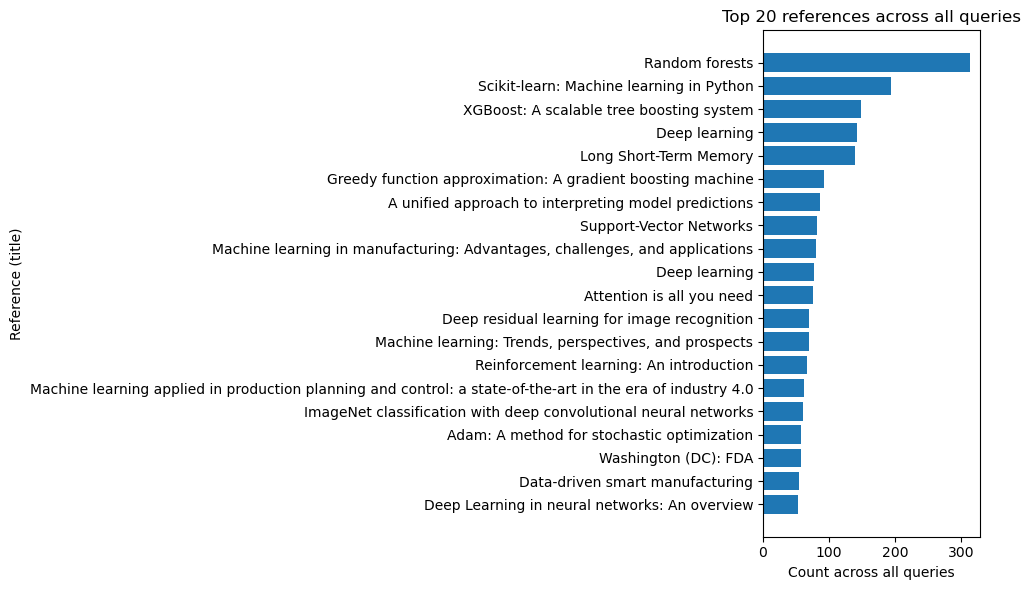

Saved figure: ../reports/figures/top_20_references.png


In [13]:
# Figure: Top references by total count

TOP_N = 20
plot_df = ref_df.head(TOP_N).copy()

# Prefer title, fall back to DOI or source title
labels = (
    pd.Series(plot_df["title"])
      .fillna(plot_df["doi"])
      .fillna(plot_df["sourcetitle"])
      .fillna(plot_df["ref_key_value"])
)

plt.figure(figsize=(10, 6))
plt.barh(range(len(plot_df)), plot_df["count"])
plt.yticks(range(len(plot_df)), labels)
plt.gca().invert_yaxis()
plt.xlabel("Count across all queries")
plt.ylabel("Reference (title)")
plt.title(f"Top {TOP_N} references across all queries")
plt.tight_layout()

fig_path = Path(figure_path) / f"top_{TOP_N}_references.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure: {fig_path}")


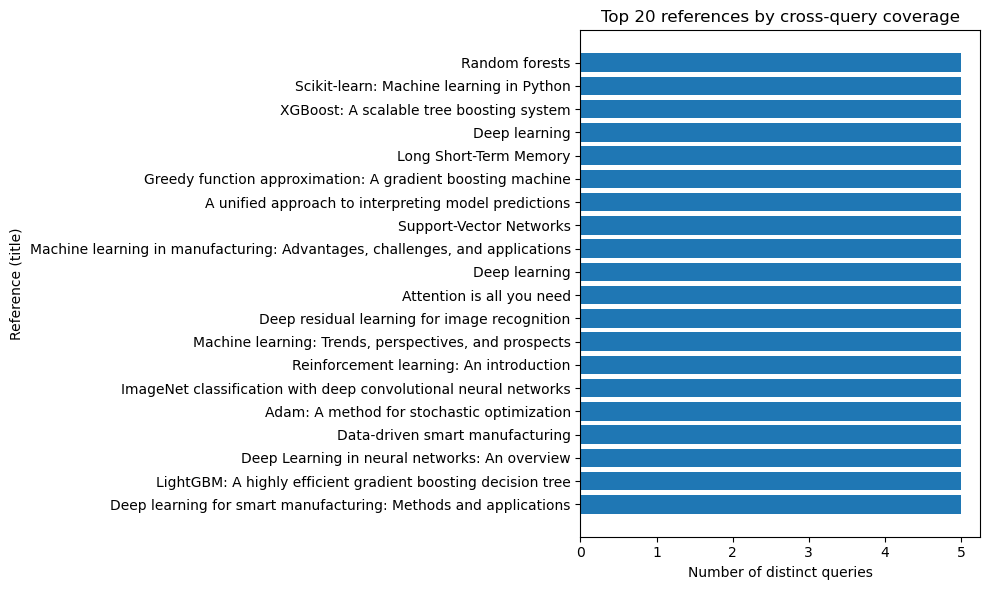

Saved figure: ../reports/figures/top_20_references_by_coverage.png


In [14]:
# Figure: Top references by distinct query coverage

TOP_N = 20
plot_df = (
    ref_df.sort_values(["n_queries", "count"], ascending=[False, False])
          .head(TOP_N)
          .copy()
)

labels = (
    pd.Series(plot_df["title"])
      .fillna(plot_df["doi"])
      .fillna(plot_df["sourcetitle"])
      .fillna(plot_df["ref_key_value"])
)

plt.figure(figsize=(10, 6))
plt.barh(range(len(plot_df)), plot_df["n_queries"])
plt.yticks(range(len(plot_df)), labels)
plt.gca().invert_yaxis()
plt.xlabel("Number of distinct queries")
plt.ylabel("Reference (title)")
plt.title(f"Top {TOP_N} references by cross-query coverage")
plt.tight_layout()

fig_path = Path(figure_path) / f"top_{TOP_N}_references_by_coverage.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved figure: {fig_path}")


In [19]:
# Find references by DOI/title fragment, with per-query columns and a total row

def find_ref(fragment: str, limit: int = 50) -> pd.DataFrame:
    frag = norm_text(fragment)
    if not frag:
        return pd.DataFrame()

    hits = []
    per_query_sets = []  # collect query-id sets to know which columns to create

    for key, cnt in ref_counter.items():
        key_type, key_val = key
        meta = ref_meta.get(key, {})

        hay = " | ".join(
            x for x in [
                key_val,
                norm_text(meta.get("doi")),
                norm_text(meta.get("title")),
                norm_text(meta.get("sourcetitle")),
            ] if x
        )
        if not hay or frag not in hay:
            continue

        by_query = dict(ref_per_query.get(key, {}))
        per_query_sets.append(set(by_query.keys()))

        hits.append({
            "count": cnt,
            "n_queries": len(by_query),
            "doi": meta.get("doi"),
            "title": meta.get("title"),
            "sourcetitle": meta.get("sourcetitle"),
            "ref_key_type": key_type,
            "ref_key_value": key_val,
            "_by_query": by_query,  # temporary; expanded below
        })

    if not hits:
        return pd.DataFrame()

    # Decide which query columns to include: only those present among matches
    query_cols = sorted(set().union(*per_query_sets)) if per_query_sets else []

    # Build DataFrame and expand per-query counts into dedicated columns
    base_cols = ["count", "n_queries", "doi", "title", "sourcetitle", "ref_key_type", "ref_key_value"]
    df = pd.DataFrame(hits)
    for q in query_cols:
        df[q] = df["_by_query"].apply(lambda d: int(d.get(q, 0)))
    df = df.drop(columns=["_by_query"])

    # Order and limit rows
    sort_cols = ["count", "n_queries"]
    df = df.sort_values(sort_cols, ascending=[False, False]).head(limit).reset_index(drop=True)

    # Append a total row at the bottom
    totals = {
        "count": int(df["count"].sum()),
        "n_queries": int(df["n_queries"].sum()),  # sum across rows (informative but not unique count)
        "doi": "",
        "title": "— total —",
        "sourcetitle": "",
        "ref_key_type": "",
        "ref_key_value": "",
    }
    for q in query_cols:
        totals[q] = int(df[q].sum())

    # Ensure final column order: base meta -> per-query cols
    ordered_cols = base_cols + query_cols
    df = df.reindex(columns=ordered_cols)

    # Append total row
    df = pd.concat([df, pd.DataFrame([totals])[ordered_cols]], ignore_index=True)

    return df


In [21]:
# Example:
find_ref("knn")

,count,n_queries,doi,title,sourcetitle,ref_key_type,ref_key_value,ml_manufacturing_optimization,ml_planning_production,ml_product_design,ml_product_development,ml_production_optimization
0,6,4,10.1007/978-3-540-39964-3_62,KNN model-based approach in classification,Lecture Notes in Computer Science (including s...,doi,10.1007/978-3-540-39964-3_62,1,2,2,0,1
1,3,3,10.1109/TKDE.2021.3049250,Challenges in KNN Classification,IEEE Transactions on Knowledge and Data Engine...,doi,10.1109/tkde.2021.3049250,1,0,1,0,1
2,3,3,10.3233/IDT-220233,Modified Euclidean-Canberra blend distance met...,Intelligent Decision Technologies,doi,10.3233/idt-220233,1,1,0,0,1
3,3,3,10.3390/electronics10101169,Enhancement of ship type classification from a...,Electronics (Switzerland),doi,10.3390/electronics10101169,1,1,0,0,1
4,3,3,10.1007/s11269-019-02273-0,"A Comparative Study of MLR, KNN, ANN and ANFIS...",Water Resources Management,doi,10.1007/s11269-019-02273-0,0,1,1,0,1
5,3,2,10.1016/j.arabjc.2023.104833,Development of advanced machine learning model...,Arabian Journal of Chemistry,doi,10.1016/j.arabjc.2023.104833,0,2,0,0,1
6,3,2,None,Application of K-Nearest Neighbor (KNN) Approa...,Int. J. Eng. Res. Appl,title,application of k-nearest neighbor knn approach...,0,1,0,2,0
7,3,2,10.1016/j.eswa.2018.03.005,Dealing with seasonality by narrowing the trai...,Expert Systems with Applications,doi,10.1016/j.eswa.2018.03.005,0,2,0,0,1
8,3,1,10.1016/j.ifacol.2021.08.045,A kNN approach based on ICP metrics for 3D sca...,IFAC-PapersOnLine,doi,10.1016/j.ifacol.2021.08.045,0,3,0,0,0
9,2,2,10.1016/j.compag.2023.108556,Vibration-based monitoring of agro-industrial ...,Computers and Electronics in Agriculture,doi,10.1016/j.compag.2023.108556,1,0,0,0,1
